## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on amygdala (later hippocampus and vmPFC)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

from utils import calcBF

In [3]:
## Load amygdala database
df = pd.read_csv('amg_TraumavsNeutral.csv')#('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg1','amg2','amg3'])
df_long

,scr_id,groupIdx,variable,value
0,KPE008,1,amg1,0.384864
1,KPE1223,1,amg1,0.072214
2,KPE1253,0,amg1,-0.142767
3,KPE1263,0,amg1,-0.254799
4,KPE1293,1,amg1,-0.054429
...,...,...,...,...
76,KPE1561,0,amg3,0.184200
77,KPE1573,1,amg3,0.391631
78,KPE1578,0,amg3,-0.246893
79,KPE1587,1,amg3,NaN


In [4]:
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        amg1      13.0  0.091727  0.382140 -0.344641 -0.142767 -0.013621   
         amg2      12.0  0.186816  0.296849 -0.292027  0.030829  0.167474   
         amg3      10.0  0.151494  0.383857 -0.246893 -0.155534  0.091739   
1        amg1      14.0 -0.010331  0.397779 -0.760030 -0.222873  0.008892   
         amg2      14.0 -0.153388  0.337935 -0.702461 -0.325189 -0.173664   
         amg3      12.0 -0.149890  0.357468 -0.721853 -0.334502 -0.190697   

                                       
                        75%       max  
groupIdx variable                      
0        amg1      0.221137  0.990817  
         amg2      0.287380  0.859317  
         amg3      0.288222  0.906373  
1        amg1      0.309385  0.533188  
         amg2      0.015790  0.433613  
         amg3      0.153811  0.391631

In [5]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

               Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     value   
No. Observations:       75          Method:                 REML    
No. Groups:             27          Scale:                  0.1022  
Min. group size:        2           Log-Likelihood:         -33.7749
Max. group size:        3           Converged:              Yes     
Mean group size:        2.8                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.092    0.100  0.917 0.359 -0.104  0.288
variable[T.amg2]           0.093    0.128  0.725 0.469 -0.159  0.345
variable[T.amg3]           0.056    0.136  0.410 0.682 -0.211  0.322
groupIdx                  -0.102    0.139 -0.735 0.463 -0.374  0.170
variable[T.amg2]:groupIdx -0.236    0.176 -1.339 0

In [6]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     1.212      1     19  1.212  6.116    0.023  0.244  nan
variable     0.016      2     38  0.008  0.079    0.924  0.004    0.939
Interaction  0.380      2     38  0.190  1.888    0.165  0.090  nan



In [7]:
pg.ttest(df.amg2[df.groupIdx==1], df.amg2[df.groupIdx==0], paired=False, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.704474,24,two-sided,0.012379,"[-0.6, -0.08]",1.063934,4.382,0.737294


In [8]:
pg.ttest(df.amg1[df.groupIdx==1], df.amg1[df.groupIdx==0], paired=False, correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.678805,25,two-sided,0.503498,"[-0.41, 0.21]",0.261452,0.425,0.10011


In [9]:
pg.ttest(df.amg3[df.groupIdx==1], df.amg3[df.groupIdx==0], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.904562,20,two-sided,0.071321,"[-0.63, 0.03]",0.815485,1.331,0.441659


### As requested from Reviewer 1 - adding withing group time analysis

In [10]:
### Start with simple GLM models (using statsmodel)
df_longKet = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longKet, groups = df_longKet.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())
aov = pg.rm_anova(data=df_longKet, dv='value', within='variable',
                     subject='scr_id',  effsize="np2")
pg.print_table(aov)

# t test to compare each time to baseline
pg.ttest(df.amg1[df.groupIdx==1], df.amg2[df.groupIdx==1], paired=True, correction=False)


           Mixed Linear Model Regression Results
Model:               MixedLM  Dependent Variable:  value   
No. Observations:    40       Method:              REML    
No. Groups:          14       Scale:               0.0971  
Min. group size:     2        Log-Likelihood:      -17.9828
Max. group size:     3        Converged:           Yes     
Mean group size:     2.9                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        -0.010    0.098 -0.106 0.916 -0.202  0.181
variable[T.amg2] -0.143    0.118 -1.215 0.224 -0.374  0.088
variable[T.amg3] -0.127    0.124 -1.030 0.303 -0.370  0.115
Group Var         0.037    0.112                           


ANOVA SUMMARY

Source      ddof1    ddof2      F    p-unc    np2    eps
--------  -------  -------  -----  -------  -----  -----
variable        2       22  1.221    0.3

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.59192,13,two-sided,0.135417,"[-0.05, 0.34]",0.387613,0.751,0.269529


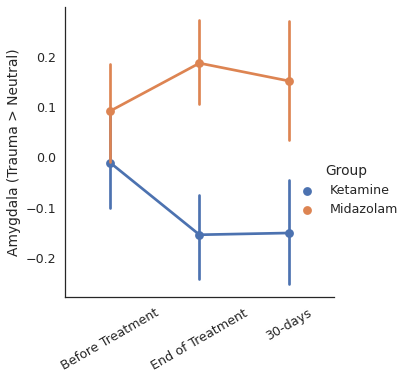

In [11]:
sns.set(font_scale = 1.15)
sns.set_style("white")
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "End of Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala (Trauma > Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_pointGraph.png', dpi=300, bbox_inches='tight')

In [12]:
# Bayes
# take indexes for building the model
df_longKet['scr_id'] = df_longKet.scr_id.astype('category')
sub_idx = df_longKet.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_longKet.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_longKet.variable = pd.Categorical(df_longKet.variable, 
                    categories=['amg1','amg2','amg3'])
timeIDX = df_longKet.variable.cat.codes.values
print(timeIDX)
df_longKet['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13  0  1  2  3  4  5  6  7  8  9
 10 11 12 13  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
14
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2]


In [13]:
with pm.Model() as hierarchical:   
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
    b = pm.Normal('b', mu=0, sd=0.1, shape=3)
    
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_longKet.value)
    
    trace = pm.sample(draws=1000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [ ]:
az.summary(trace, hdi_prob=.9)

In [ ]:
diffTime = trace.posterior['b'].data[:,:,1] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
plt.show()
sns.distplot(trace.posterior['b'].data[:,:,2], color='red')
sns.distplot(trace.posterior['b'].data[:,:,0])
sns.distplot(trace.posterior['b'].data[:,:,1], color= 'orange')
print(sum(diffTime.ravel()>0)/len(diffTime.ravel()))

## Build a Bayesian model
- Here we would model each subject under each group

In [ ]:
# first lets look at the data
sns.pairplot(df[['amg1','amg2','amg3','groupIdx']], hue='groupIdx', kind='scatter')

In [ ]:
df_long.groupby(['groupIdx', 'variable']).describe()

In [ ]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("Time")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)
g.set_xlabels('')
g.set_ylabels("Amygdala (Trauma vs. Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_pointGraph.png', dpi=300, bbox_inches = 'tight')

# Interaction model 
- Include baseline as covariate

In [15]:
## Load amygdala database
df = pd.read_csv('amg_TraumavsNeutral.csv')#('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long2 = pd.melt(df, id_vars=['scr_id','groupIdx', 'amg1'], value_vars=['amg2','amg3'])
#df_long2

In [16]:
# take indexes for building the model
df_long2['scr_id'] = df_long2.scr_id.astype('category')
sub_idx = df_long2.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long2.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long2.variable = pd.Categorical(df_long2.variable, 
                    categories=['amg2','amg3'])
timeIDX = df_long2.variable.cat.codes.values
print(timeIDX)
df_long2['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26]
27
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [17]:
## Run similar model but without hyperpriors
# now we build a model - modeling the score of each group on each time point
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
    cov = pm.Normal('cov', mu=0.05, sd=0.1)
    b = pm.Normal('b', mu=0, sd=0.1, shape=2)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
   # sigma = pm.HalfCauchy('sigma', 1)
    interact = pm.Normal('interaction', mu=0, sd=1, shape=(2,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,df_long2.groupIdx] + cov*df_long2.amg1

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long2.value)
    
    
    # calculate differences and effect size
    diff_of_means1 = pm.Deterministic('differenceGroups end of treatment', interact[0,1] - interact[0,0])
    diff_of_means2 = pm.Deterministic('differenceGroups 30 days', interact[1,1] - interact[1,0])
   
    # effect size
    effect_size1 = pm.Deterministic('effect size2_1', 
                        abs(diff_of_means1) / eps)
    
    effect_size2 = pm.Deterministic('effect size3_1', 
                        abs(diff_of_means2) / eps)
    
#     effect_size3 = pm.Deterministic('effect size4_1', 
#                         abs(diff_of_means3) / eps)
    
    ppChecks = pm.sample_prior_predictive(samples = 8000)
    trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


In [18]:
az.summary(trace, hdi_prob=prob = .9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.004,0.092,-0.141,0.163,0.001,0.001,15910.0,5899.0,1.0
a[1],0.015,0.089,-0.131,0.158,0.001,0.001,15622.0,5820.0,1.0
a[2],-0.027,0.096,-0.178,0.137,0.001,0.001,15132.0,6314.0,1.0
a[3],0.043,0.091,-0.103,0.195,0.001,0.001,16010.0,5873.0,1.0
a[4],-0.004,0.093,-0.156,0.149,0.001,0.001,17481.0,5417.0,1.0
a[5],-0.044,0.093,-0.200,0.107,0.001,0.001,15633.0,5988.0,1.0
a[6],0.008,0.097,-0.149,0.167,0.001,0.001,15296.0,6439.0,1.0
a[7],-0.031,0.090,-0.182,0.111,0.001,0.001,15999.0,6003.0,1.0
a[8],-0.005,0.091,-0.156,0.142,0.001,0.001,17057.0,5817.0,1.0
a[9],-0.059,0.094,-0.207,0.100,0.001,0.001,17239.0,5727.0,1.0


<AxesSubplot:ylabel='Count'>

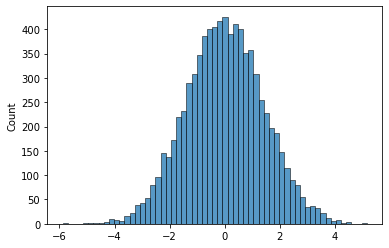

In [27]:
priorC = ppChecks['interaction'][:,1,0] - ppChecks['interaction'][:,1,1] 
sns.histplot(priorC)

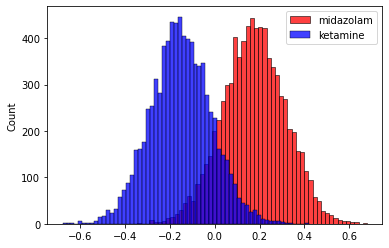

In [17]:
tr = trace.posterior.stack(draws=("chain", "draw"))
sns.histplot(tr.interaction.values[0,0,:,], label='midazolam', color='red')
sns.histplot(tr.interaction.values[0,1,:], label = 'ketamine', color='blue')
plt.legend()

## BF

In [28]:
after = tr.interaction.values[1,0,:,]  - tr.interaction.values[1,1,:,]
#bf_aftertrtr = calcBF(y1=after, y2=priorC)

In [ ]:
#t_delt = trace[varname]
from scipy import stats
posterior = stats.kde.gaussian_kde(after)
prior = stats.kde.gaussian_kde(priorC)
prior_h0 = prior(0)  # this gives the pdf at point delta = 0
posterior_h0 =posterior(0)  # this gives the pdf at point delta = 0
BF01 =   prior_h0  / posterior_h0
print("the Bayes Factor is %.5f" % (BF01))

## Another option for BF

In [29]:
# calculating the overlap between the two distributions
y2 = priorC#trace['b'][:,0]
y1 = after#trace['b'][:,1]
from scipy import stats

xmin, xmax = -4., 4.
x_pts = np.mgrid[xmin:xmax:4000]


ker_b = stats.gaussian_kde(y1)
ker_a = stats.gaussian_kde(y2)
kde_a = np.reshape(ker_a(x_pts).T, x_pts.shape)
kde_b = np.reshape(ker_b(x_pts).T, x_pts.shape)


# Random sample from a KDE distribution.
sample = ker_a.resample(size=4000)

# Compute the points below which to integrate.
iso = ker_b(sample)

# Filter the sample.
insample = ker_a(sample) < iso

# As per Monte Carlo, the integral is equivalent to the
# probability of drawing a point that gets through the
# filter.
integral = float(insample.shape[0]) / insample.sum()  

integral

5.856515373352855

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)

In [ ]:
az.summary(traceSes2, hdi_prob=.9)

In [ ]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)

In [ ]:
az.summary(traceSes3, hdi_prob=.9)

## Using a different method for assessing

In [ ]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=4000, tune=2000,target_accept=0.9, return_inferencedata=False)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [ ]:
ses1trace, ses1Diff = runModel('amg1')

In [ ]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

In [ ]:
ses2trace, ses2Diff = runModel('amg2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

In [ ]:
ses3trace, ses3Diff = runModel('amg3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting

In [ ]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(-0.8, 1)#(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
   # ax1.set_xlabel("Group", fontsize=14)
    fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

In [ ]:
def plotSubfigs(subfigs,subNum, depVar,indepVar, trace, title):
    # gets subfig and the index number of it to plot the same as above
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    axsLeft = subfigs[subNum].subplots(1,2, gridspec_kw={'width_ratios': [1, .2],'wspace':.01})
    ax1 = axsLeft[0]
    ax2 = axsLeft[1]
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                 boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
                linewidth = 3, linestyle = "-")

    ax2.set_ylim(-0.8, 1)#(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax1.set_ylim(-0.8, 1)
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Amg reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel('')#("Group", fontsize=14)
    ax1.set_title(title, fontsize=15)
    #ax1.title.set_style(font="large")

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
subfigs = fig.subfigures(1, 3, wspace=0.1)
plotSubfigs(subfigs, 0, 'amg1','groupIdx',traceSes1, "Before Treatment")
#subfigs[0].suptitle('Before Treatment', fontsize='large')
plotSubfigs(subfigs, 1, 'amg2','groupIdx',traceSes2, 'After Treatment')
#subfigs[1].suptitle('After Treatment', fontsize='large')
plotSubfigs(subfigs, 2,'amg3','groupIdx',traceSes3, '30-Days')
#subfigs[2].suptitle('Follow-Up', fontsize='large')
fig.savefig("Amg_reactivity.png",  dpi=300, bbox_inches='tight')

In [ ]:
pg.ttest(df.amg2[df.groupIdx==1], df.amg2[df.groupIdx==0])

In [ ]:
pg.ttest(df.amg3[df.groupIdx==1], df.amg3[df.groupIdx==0])